In [1]:
#pip install --upgrade google-api-python-client

In [2]:
#pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [3]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]

In [5]:
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    
api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret_615288565318-dd7us4i9infmai01fr3n2nlff2cb44f3.apps.googleusercontent.com.json"
    
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=615288565318-dd7us4i9infmai01fr3n2nlff2cb44f3.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.force-ssl&state=4o2DHFBa7cNkpa9f8kuAEjdnnArWNc&prompt=consent&access_type=offline
Enter the authorization code: 4/1AY0e-g5giuSln_iucfQezTtzSUAxt3ahui97VhLEGjBFU4OthdMNk_vcos4


In [6]:
def simple_search(keywords, num_results):
    request = youtube.search().list(
        q=keywords,
        part="id",
        type="video",
        fields="items/id",
        maxResults=num_results
    )
    response = request.execute()
    
    videos = []
    for search_result in response.get("items",[]):
        videos.append("%s" % (search_result["id"]["videoId"]))
    
    return videos

In [7]:
def get_statistics(video_ids):
    statistics = []
    for vid_id in video_ids:
        request = youtube.videos().list(part="statistics",id=vid_id)
        response = request.execute()
        statistics.append(response)
    
    return statistics

In [8]:
def parse_statistics(video_stats):
    stat_dict = {}
    stat_dict['views'] = []
    stat_dict['likes'] = []
    stat_dict['dislikes'] = []
    stat_dict['comments'] = []
    
    for vid_stat in video_stats:
        try:
            stat_dict['views'].append(int(vid_stat['items'][0]['statistics']['viewCount']))
        except:
            stat_dict['views'].append(0)
        
        try:
            stat_dict['likes'].append(int(vid_stat['items'][0]['statistics']['likeCount']))
        except:
            stat_dict['likes'].append(0)
            
        try:
            stat_dict['dislikes'].append(int(vid_stat['items'][0]['statistics']['dislikeCount']))
        except:
            stat_dict['dislikes'].append(0)
            
        try:
            stat_dict['comments'].append(int(vid_stat['items'][0]['statistics']['commentCount']))
        except:
            stat_dict['comments'].append(0)
    
    return stat_dict

In [9]:
def determine_target (video_views):
    target = []
#    for i in range(len(video_views)):
#        temp1 = int(video_views[i])
#        temp2 = int(channel_subscribers[i])
#        if temp1 > temp2:
#            target.append(1)
#        else:
#            target.append(0)
    for views in video_views:
        if views > 1000000:
            target.append(1)
        else:
            target.append(0)
    return target

In [10]:
music_vids=simple_search("music",25)
sports_vids=simple_search("sports",25)
gaming_vids=simple_search("gaming",25)
movies_vids=simple_search("movies and shows",25)
news_vids=simple_search("news",25)
live_vids=simple_search("live",25)
fashion_vids=simple_search("fashion and beauty",25)
learning_vids=simple_search("learning",25)

In [11]:
ids_df = pd.DataFrame(data=music_vids+sports_vids+gaming_vids+movies_vids+news_vids+live_vids+fashion_vids+learning_vids,columns=["Video_IDs"])
print(ids_df)

       Video_IDs
0    zXVNxSM3-Bo
1    PuJQhtg1VCM
2    xNV38nq1fqc
3    W9iUh23Xrsg
4    gvU_8LNK00E
..           ...
195  YS7vsBgWszI
196  Hd6QgsXB7Y0
197  bNVQkoCfr6g
198  KVyW34E1UP4
199  raMEQzGVY3w

[200 rows x 1 columns]


In [12]:
video_stats = get_statistics(ids_df['Video_IDs'])
print(video_stats)

[{'kind': 'youtube#videoListResponse', 'etag': 'M4XkCHugNr3TX9h_ieaqLtCZ5PU', 'items': [{'kind': 'youtube#video', 'etag': '46GCJeH4F_BywaagUxmXXWOpOs8', 'id': 'zXVNxSM3-Bo', 'statistics': {'viewCount': '21105', 'likeCount': '439', 'dislikeCount': '14', 'favoriteCount': '0', 'commentCount': '0'}}], 'pageInfo': {'totalResults': 1, 'resultsPerPage': 1}}, {'kind': 'youtube#videoListResponse', 'etag': 'UaIjXgnEJG_FgDpyGYOWy7jr920', 'items': [{'kind': 'youtube#video', 'etag': 'e94l_AxRPoGaGptchWM_Dx-az9E', 'id': 'PuJQhtg1VCM', 'statistics': {'viewCount': '19904254', 'likeCount': '115135', 'dislikeCount': '7579', 'favoriteCount': '0', 'commentCount': '10492'}}], 'pageInfo': {'totalResults': 1, 'resultsPerPage': 1}}, {'kind': 'youtube#videoListResponse', 'etag': '8lcaKwB3dAt0wqOZ2uGEIgRv-Zo', 'items': [{'kind': 'youtube#video', 'etag': 'jxOskYbn7_EfTSFjS6-U7MUBa4g', 'id': 'xNV38nq1fqc', 'statistics': {'viewCount': '20880105', 'likeCount': '95021', 'dislikeCount': '11321', 'favoriteCount': '0',

In [13]:
parsed_stats = parse_statistics(video_stats)
print(parsed_stats)

{'views': [21105, 19904254, 20880105, 31535600, 840875, 299446905, 61670, 196871, 5453919, 102353, 16882923, 77745102, 2470, 122464, 130198845, 371593700, 154108825, 1439740031, 76956, 308979025, 311192, 332483739, 2029117170, 3007344755, 1512410, 7396890, 390671, 49218144, 6966443, 3435126, 8297684, 41904, 4307484, 14454128, 59638698, 14523764, 2035826, 1147064, 1160027, 20129, 28973797, 96596, 509643, 397804, 1527077, 6928290, 195223, 855065, 225831, 1506010, 8730079, 255522, 1702877, 3068799, 29902903, 1289449, 2103982, 3410125, 42754, 21038094, 27090804, 870240, 2319117, 418415, 26699024, 2829872, 960669, 107104, 14499234, 41943942, 985660, 2503306, 1034359, 154314, 182944, 23001457, 1431707, 120291502, 438487, 146373, 212976, 6881782, 91434, 195114, 374251, 25490, 17436899, 225389, 164324, 61942, 16268, 10192995, 3750, 71232, 175602, 169335, 260086, 102589, 97874, 218531, 163240, 347661, 30164, 96871, 11153911, 666196, 253232, 1193573, 1040793, 96541, 30915, 658785, 418594, 312306

In [14]:
video_df = pd.DataFrame(data = parsed_stats)
print(video_df)

         views   likes  dislikes  comments
0        21105     439        14         0
1     19904254  115135      7579     10492
2     20880105   95021     11321      2961
3     31535600  304997     11896     10721
4       840875  110177       935     26344
..         ...     ...       ...       ...
195    6773254   22911      2434       679
196   86173656  515082     66963         0
197  101477169  455561    294617      1033
198    3922360   11016      2480         0
199   29795025   35033     10985      1414

[200 rows x 4 columns]


In [15]:
target = determine_target(video_df['views'])
print(target)

[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
video_df['target'] = target
video_df.head()

,views,likes,dislikes,comments,target
0,21105,439,14,0,0
1,19904254,115135,7579,10492,1
2,20880105,95021,11321,2961,1
3,31535600,304997,11896,10721,1
4,840875,110177,935,26344,0


In [17]:
scaler = StandardScaler()
scaler.fit(video_df.drop(['views', 'target'], axis = 1))
scaled_features = scaler.transform(video_df.drop(['views', 'target'], axis = 1))
df_features = pd.DataFrame(scaled_features, columns = ['likes', 'dislikes', 'comments'])
print(df_features)

        likes  dislikes  comments
0   -0.226010 -0.277697 -0.222143
1   -0.175713 -0.200270 -0.113423
2   -0.184534 -0.161971 -0.191460
3   -0.092456 -0.156086 -0.111050
4   -0.177888 -0.268271  0.050837
..        ...       ...       ...
195 -0.216155 -0.252929 -0.215107
196 -0.000330  0.407522 -0.222143
197 -0.026431  2.737547 -0.211439
198 -0.221371 -0.252458 -0.222143
199 -0.210840 -0.165410 -0.207491

[200 rows x 3 columns]


In [18]:
x = df_features
y = video_df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 101)

In [19]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)
predict = knn.predict(x_test)
predict

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

In [20]:
print (confusion_matrix(y_test, predict))
print (classification_report(y_test, predict))

[[32  2]
 [ 4 22]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.92      0.85      0.88        26

    accuracy                           0.90        60
   macro avg       0.90      0.89      0.90        60
weighted avg       0.90      0.90      0.90        60



In [21]:
error_rate = []
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    predict_i = knn.predict(x_test)
    error_rate.append(np.mean(predict_i!=y_test))

error_rate

[0.1,
 0.13333333333333333,
 0.13333333333333333,
 0.15,
 0.15,
 0.11666666666666667,
 0.1,
 0.11666666666666667,
 0.1,
 0.1,
 0.11666666666666667,
 0.1,
 0.11666666666666667,
 0.13333333333333333,
 0.13333333333333333,
 0.11666666666666667,
 0.1,
 0.11666666666666667,
 0.1,
 0.13333333333333333,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.11666666666666667,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.13333333333333333,
 0.15,
 0.15,
 0.16666666666666666,
 0.15,
 0.16666666666666666,
 0.15,
 0.18333333333333332,
 0.16666666666666666,
 0.18333333333333332,
 0.18333333333333332,
 0.2,
 0.2,
 0.18333333333333332,
 0.18333333333333332,
 0.18333333333333332,
 0.1833333

Text(0, 0.5, 'Error rate')

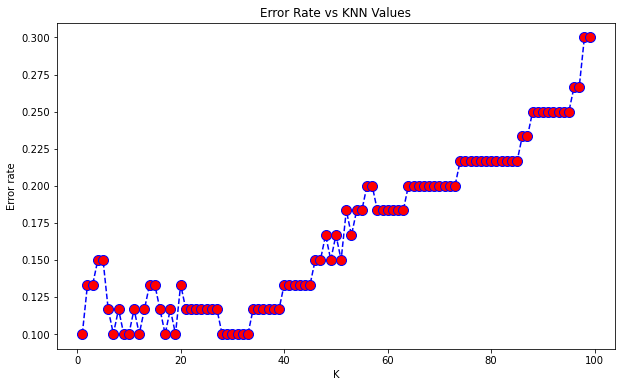

In [22]:
plt.figure(figsize = (10,6))
plt.plot(range(1,100), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markersize = 10, markerfacecolor = 'red')
plt.title('Error Rate vs KNN Values')
plt.xlabel('K')
plt.ylabel('Error rate')